In [28]:
from bwb.transports import SinkhornTransport, EMDTransport

In [29]:
import numpy as np

data = np.load(r"..\data\face.npy")
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [30]:
%%time
from bwb.distributions import DistributionDrawBuilder


CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)

CPU times: total: 8.12 s
Wall time: 11.1 s


In [31]:
from bwb.utils import plot_list_of_draws, freq_labels_posterior

plot_list_of_draws(faces_original)

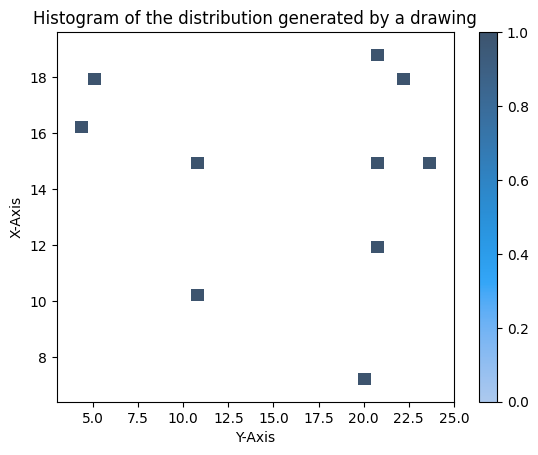

In [32]:
from matplotlib import pyplot as plt
from bwb.utils import plot_histogram_from_points
from bwb.distributions import DistributionDraw

first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=10)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

# Instanciando y "quemando" el MCMC

In [33]:
%%time
from bwb.distributions import GibbsPosteriorPiN

pi_n = GibbsPosteriorPiN(data=x, models=faces_original[1:], seed=rng)

CPU times: total: 48.1 s
Wall time: 49.6 s


In [34]:
# %%time
# pi_n.rvs(size=1_000)
# pi_n

In [35]:
# print(f"{len(pi_n.counter.most_common()) = }")
# pi_n.counter.most_common()

In [36]:
# plot_list_of_draws(pi_n.most_common(), labels=freq_labels_posterior(pi_n))

# Algoritmo del descenso del gradiente estocástico

Ahora se programará el descenso del gradiente estocástico usando la posterior $\Pi_n$

In [37]:
def as_matrix(weights, places, shape):
    assert len(weights) == len(places), f"El tamaño de los pesos y de los puntos soporte no coinciden: {len(weights) = }, {len(places) = }"

    to_return = np.zeros(shape)
    for row, weight in zip(places.astype(int), weights):
        to_return[tuple(row)] += weight

    return to_return

# mat = as_matrix(mu_s, Xs, mu_0.shape)

from bwb.utils import plot_list_of_draws
from PIL import Image

def matrix_to_image_array(matrix: np.ndarray):
    matrix_: np.ndarray = np.ceil(255 - 255 * matrix / matrix.max())
    return matrix_.astype("uint8")

# im = Image.fromarray(matrix_to_image_array(mat))
# plot_list_of_draws([DistributionDraw(im)])

In [38]:
def gamma(t, a=3, b=4, c=1):
    return a * (b + t) ** -c

for t in range(100):
    print(f"{t = }; {gamma(t) = :.8f}")

t = 0; gamma(t) = 0.75000000
t = 1; gamma(t) = 0.60000000
t = 2; gamma(t) = 0.50000000
t = 3; gamma(t) = 0.42857143
t = 4; gamma(t) = 0.37500000
t = 5; gamma(t) = 0.33333333
t = 6; gamma(t) = 0.30000000
t = 7; gamma(t) = 0.27272727
t = 8; gamma(t) = 0.25000000
t = 9; gamma(t) = 0.23076923
t = 10; gamma(t) = 0.21428571
t = 11; gamma(t) = 0.20000000
t = 12; gamma(t) = 0.18750000
t = 13; gamma(t) = 0.17647059
t = 14; gamma(t) = 0.16666667
t = 15; gamma(t) = 0.15789474
t = 16; gamma(t) = 0.15000000
t = 17; gamma(t) = 0.14285714
t = 18; gamma(t) = 0.13636364
t = 19; gamma(t) = 0.13043478
t = 20; gamma(t) = 0.12500000
t = 21; gamma(t) = 0.12000000
t = 22; gamma(t) = 0.11538462
t = 23; gamma(t) = 0.11111111
t = 24; gamma(t) = 0.10714286
t = 25; gamma(t) = 0.10344828
t = 26; gamma(t) = 0.10000000
t = 27; gamma(t) = 0.09677419
t = 28; gamma(t) = 0.09375000
t = 29; gamma(t) = 0.09090909
t = 30; gamma(t) = 0.08823529
t = 31; gamma(t) = 0.08571429
t = 32; gamma(t) = 0.08333333
t = 33; gamma(t) = 0

In [39]:
%%time
eps = 1e-3
alpha = 1. / 10
emd_transp = EMDTransport()
max_iter = 150

# Camino de baricentros
mu = []

# Paso 1: samplear un mu_0
mu_0: DistributionDraw = pi_n.draw()
mu.append(mu_0)

# Calcular las masas y ubicaciones
Xs, mu_s = [], []
min_w, max_w = mu_0.weights.min(), mu_0.weights.max()

for x, w, n in zip(mu_0.support, mu_0.weights, np.ceil(alpha * mu_0.weights / min_w).astype(int)):
    for _ in range(n):
        Xs.append(x)
        mu_s.append(w / n)

Xs = np.array(Xs)
mu_s = np.array(mu_s)

print(f"{len(Xs) = }")

k = 0

while k < max_iter:
    print("="*10 + f" {k = } " + "="*10)
    # Paso 2: Samplear \tilde\mu_k
    t_mu_k: DistributionDraw = pi_n.draw()
    Xt, mu_t = np.array(t_mu_k.support), np.array(t_mu_k.weights)

    # Calcular transporte óptimo
    emd_transp.fit_wm(
        Xs=Xs, mu_s=mu_s,
        Xt=Xt, mu_t=mu_t,
    )

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k); print(f"{gamma_k = :.6f}")
    transport = emd_transp.transform(Xs)
    Xs_ = (1 - gamma_k) * Xs + gamma_k * transport  # Basta con calcular las transformaciones, porque los pesos son los mismos

    # Calcular la distancia de Wasserstein
    diff = Xs - transport
    W_mu_kp1_mu_k = (gamma_k ** 2) * np.sum(mu_s * np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
    print(f"{W_mu_kp1_mu_k = }")

    # Condición de detención
    if W_mu_kp1_mu_k < eps:
        break

    Xs = Xs_
    mat = as_matrix(mu_s, Xs, mu_0.shape)
    im = Image.fromarray(matrix_to_image_array(mat))
    mu.append(DistributionDraw(im))
    k += 1


len(Xs) = 3472
========== k = 0 ==========
gamma_k = 0.750000
W_mu_kp1_mu_k = 0.6912523384233489
========== k = 1 ==========
gamma_k = 0.600000
W_mu_kp1_mu_k = 0.3459869139804413
========== k = 2 ==========
gamma_k = 0.500000
W_mu_kp1_mu_k = 0.25901357782104106
========== k = 3 ==========
gamma_k = 0.428571
W_mu_kp1_mu_k = 0.18925489483279645
========== k = 4 ==========
gamma_k = 0.375000
W_mu_kp1_mu_k = 0.21895773587148823
========== k = 5 ==========
gamma_k = 0.333333
W_mu_kp1_mu_k = 0.08758131701441174
========== k = 6 ==========
gamma_k = 0.300000
W_mu_kp1_mu_k = 0.0841843535057205
========== k = 7 ==========
gamma_k = 0.272727
W_mu_kp1_mu_k = 0.1179652116037695
========== k = 8 ==========
gamma_k = 0.250000
W_mu_kp1_mu_k = 0.0535105798128959
========== k = 9 ==========
gamma_k = 0.230769
W_mu_kp1_mu_k = 0.06798375792394794
========== k = 10 ==========
gamma_k = 0.214286
W_mu_kp1_mu_k = 0.04605985034680121
========== k = 11 ==========
gamma_k = 0.200000
W_mu_kp1_mu_k = 0.0365274733

Primeras iteraciones del algoritmo

In [40]:
plot_list_of_draws(mu, max_images=36)

últimas iteraciones del algoritmo

In [41]:
plot_list_of_draws(mu[-36:], max_images=36)

# Descenso del gradiente estocástico, versión con Batch

In [42]:
%%time
eps = 1e-3
alpha = 1. / 10
emd_transp = EMDTransport()
# gamma = lambda k_: 1 / (k_ + 2)
S = lambda k_: 5
max_iter = 150

# Camino de baricentros
mu = []

# Paso 1: samplear un mu_0
mu_0: DistributionDraw = pi_n.draw()
mu.append(mu_0)

# Calcular las masas y ubicaciones
Xs, mu_s = [], []
min_w, max_w = mu_0.weights.min(), mu_0.weights.max()

for x, w, n in zip(mu_0.support, mu_0.weights, np.ceil(alpha * mu_0.weights / min_w).astype(int)):
    for _ in range(n):
        Xs.append(x)
        mu_s.append(w / n)

Xs = np.array(Xs)
mu_s = np.array(mu_s)

print(f"{len(Xs) = }")

k = 0

while k < max_iter:
    print("="*10 + f" {k = } " + "="*10)
    transports = []
    for j in range(S(k)):
        print(f"{j = }")
        # Paso 2: Samplear \tilde\mu_k
        t_mu_k: DistributionDraw = pi_n.draw()
        Xt, mu_t = np.array(t_mu_k.support), np.array(t_mu_k.weights)

        # Calcular transporte óptimo
        emd_transp.fit_wm(
            Xs=Xs, mu_s=mu_s,
            Xt=Xt, mu_t=mu_t,
        )

        transports.append(emd_transp.transform(Xs))

    # Calcular la distribución de mu_{k+1}
    gamma_k = gamma(k); print(f"{gamma_k = :.6f}")
    transport = np.mean(transports, axis=0)
    Xs_ = (1 - gamma_k) * Xs + gamma_k * transport  # Basta con calcular las transformaciones, porque los pesos son los mismos

    # Calcular la distancia de Wasserstein
    diff = Xs - transport
    W_mu_kp1_mu_k = (gamma_k ** 2) * np.sum(mu_s * np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
    print(f"{W_mu_kp1_mu_k = }")

    # Condición de detención
    if W_mu_kp1_mu_k < eps:
        break

    Xs = Xs_
    mat = as_matrix(mu_s, Xs, mu_0.shape)
    im = Image.fromarray(matrix_to_image_array(mat))
    mu.append(DistributionDraw(im))
    k += 1


len(Xs) = 3467
========== k = 0 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.750000
W_mu_kp1_mu_k = 0.34316857588718597
========== k = 1 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.600000
W_mu_kp1_mu_k = 0.21657701430678858
========== k = 2 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.500000
W_mu_kp1_mu_k = 0.12841042366348338
========== k = 3 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.428571
W_mu_kp1_mu_k = 0.13859681634697762
========== k = 4 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.375000
W_mu_kp1_mu_k = 0.1062744075826355
========== k = 5 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.333333
W_mu_kp1_mu_k = 0.06491776362093486
========== k = 6 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.300000
W_mu_kp1_mu_k = 0.04132784638213489
========== k = 7 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.272727
W_mu_kp1_mu_k = 0.03788065864056925
========== k = 8 ==========
j = 0
j = 1
j = 2
j = 3
j = 4
gamma_k = 0.250000
W_mu_

In [43]:
plot_list_of_draws(mu, max_images=36)

In [44]:
plot_list_of_draws(mu[-33:], max_images=36)